# Synthetic MWD generation
### This notebook generates 3 different molecular weight distributions:
#### > dataset1: GEX distribution
#### > dataset2: GEX distribution + gaussian noise
#### > dataset3: Log-normal distribution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import random

from scipy.special import gamma, gammainc
import scipy.interpolate
from scipy.integrate import quad

In [2]:
n = 100
M = np.logspace(4,6,n)

k = 1e-20
B = 2.25
alfa = 3.4
G0 = 2e5

tau = []
tau = k*M**alfa

omega = np.logspace(-3,3,100)

In [3]:
class interpolate1d(scipy.interpolate.interp1d):
    """Extend scipy interp1d to interpolate/extrapolate per axis in log space"""
    
    def __init__(self, x, y, *args, xspace='linear', yspace='linear', **kwargs):
        self.xspace = xspace
        self.yspace = yspace
        if self.xspace == 'log': x = np.log10(x)
        if self.yspace == 'log': y = np.log10(y)
        super().__init__(x, y, *args, **kwargs)
        
    def __call__(self, x, *args, **kwargs):
        if self.xspace == 'log': x = np.log10(x)
        if self.yspace == 'log':
            return 10**super().__call__(x, *args, **kwargs)
        else:
            return super().__call__(x, *args, **kwargs)

### >>> dataset1: GEX distribution

In [4]:
### Nobile e Cocchini (2003): GEX

def wGEX(M, a, b, m0):
    return (b/gamma((a+1)/b))*((M/m0)**(a+1))*np.exp(-(M/m0)**b)

def wGEX_integrand(M):
    return (b/gamma((a+1)/b))*((M/m0)**(a+1))*np.exp(-(M/m0)**b)/M

In [5]:
a = 5
b = 3
m0 = 2e5

mwd_GEX = [] #np.zeros((n,1))
mwd_GEX = wGEX(M, a, b, m0)

norm_value_GEX = quad(wGEX_integrand,min(M),max(M),limit=250)[0]

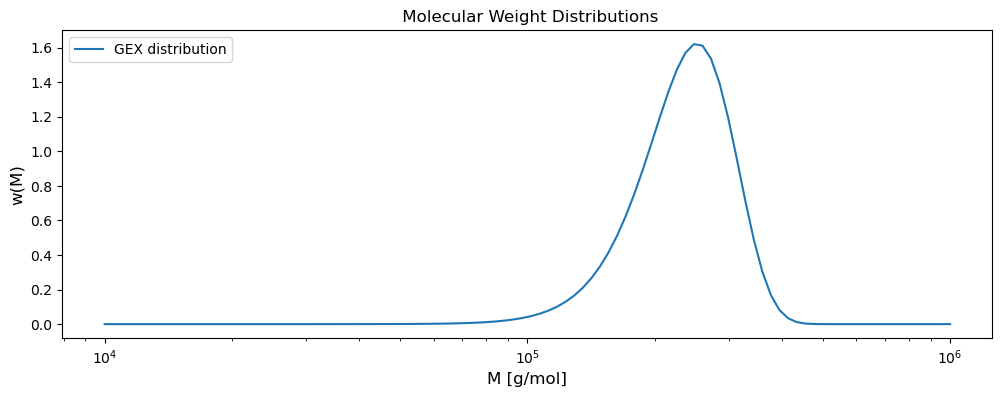

In [6]:
fig = plt.figure(figsize=(12,4),dpi=100)

plt.semilogx(M,mwd_GEX,label='GEX distribution')

plt.legend(loc='upper left')

plt.title(r' Molecular Weight Distributions')
plt.xlabel(r'M [g/mol]', fontsize=12)
plt.ylabel(r'w(M)', fontsize=12)
plt.show()

In [7]:
part_H_GEX = [] 

for x in M:
        part_H_GEX.append(quad(wGEX_integrand,x,max(M),limit=250)[0])

In [8]:
H_model_GEX = []

H_model_GEX = G0*(B/alfa)*wGEX(M,a,b,m0)*(np.array(part_H_GEX)**(B-1))

In [9]:
H_GEX_interp = interpolate1d(tau, H_model_GEX, xspace='log', fill_value='extrapolate')

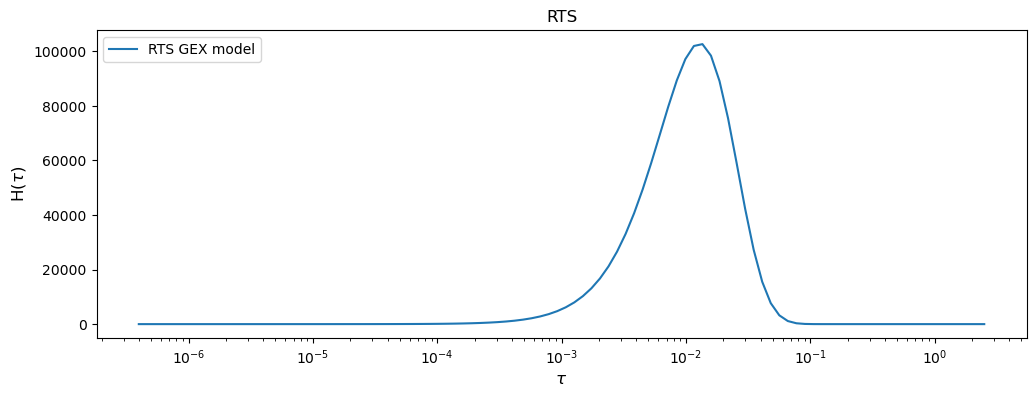

In [10]:
fig = plt.figure(figsize=(12,4),dpi=100)

plt.semilogx(tau,H_model_GEX,label='RTS GEX model')

plt.legend(loc='upper left')

plt.title(r'RTS')
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'H($\tau$)', fontsize=12)
plt.show()

In [11]:
def G1_GEX_integrand(tau):
        return (H_GEX_interp(tau)/tau)*(((w*tau)**2)/(1+((w*tau)**2)))
    
def G2_GEX_integrand(tau):
        return (H_GEX_interp(tau)/tau)*(((w*tau))/(1+((w*tau)**2)))
    
G1_GEX, G2_GEX = [], []    

for w in omega:
    G1_GEX.append(quad(G1_GEX_integrand,0,np.inf,limit=250)[0])
    G2_GEX.append(quad(G2_GEX_integrand,0,np.inf,limit=250)[0])
    
G1_GEX = np.array(G1_GEX)
G2_GEX = np.array(G2_GEX)

/tmp/ipykernel_5524/955846767.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  G2_GEX.append(quad(G2_GEX_integrand,0,np.inf,limit=250)[0])
/tmp/ipykernel_5524/955846767.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  G1_GEX.append(quad(G1_GEX_integrand,0,np.inf,limit=250)[0])


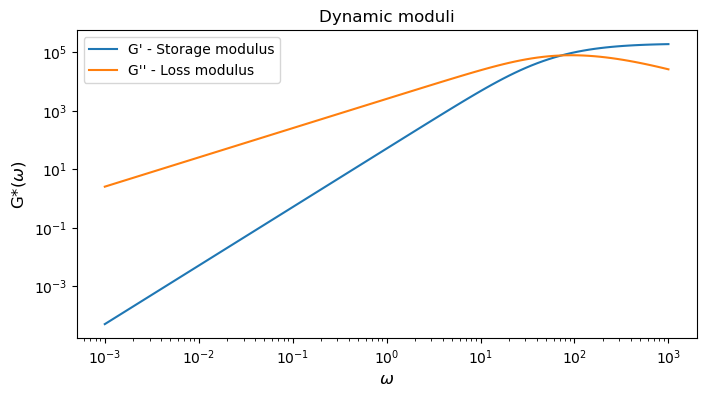

In [12]:
fig = plt.figure(figsize=(8,4),dpi=100)

plt.loglog(omega,np.array(G1_GEX),label='G\' - Storage modulus')
plt.loglog(omega,np.array(G2_GEX),label='G\'\' - Loss modulus')

plt.legend(loc='upper left')

plt.title(r'Dynamic moduli')
plt.xlabel(r'$\omega$', fontsize=12)
plt.ylabel(r'G*($\omega$)', fontsize=12)
plt.show()

In [13]:
Mn_GEX, Mw_GEX, Mz_GEX, MwMn_GEX = [], [], [], [] 

Mn_GEX = m0*(gamma((a+1)/b)/gamma(a/b))
Mw_GEX = m0*(gamma((a+2)/b)/gamma((a+1)/b))
Mz_GEX = m0*(gamma((a+3)/b)/gamma((a+2)/b))
MwMn_GEX = Mw_GEX/Mn_GEX

print('Number average molecular weight:', Mn_GEX, 'g/mol')
print('Weight average molecular weight:', Mw_GEX, 'g/mol')
print('z-Average molecular weight:', Mz_GEX, 'g/mol')
print('Polydispersity index:', MwMn_GEX, 'g/mol')

Number average molecular weight: 221546.43348649447 g/mol
Weight average molecular weight: 238127.8697517998 g/mol
z-Average molecular weight: 252734.04407804456 g/mol
Polydispersity index: 1.0748440676943514 g/mol


In [14]:
"""
with open('/path/to/MWD_dataset1.txt', 'w') as f:
    for i in range(len(M)):
        d2w = []
        d2w = str(M[i])+' '+str(mwd_GEX[i])+'\n'
        f.write(d2w)
        
with open('/path/to/G12_dataset1.txt', 'w') as f:
    for i in range(len(omega)):
        d2w = []
        d2w = str(omega[i])+' '+str(G1_GEX[i])+' '+str(G2_GEX[i])+'\n'
        f.write(d2w)
"""

"\nwith open('/path/to/MWD_dataset1.txt', 'w') as f:\n    for i in range(len(M)):\n        d2w = []\n        d2w = str(M[i])+' '+str(mwd_GEX[i])+'\n'\n        f.write(d2w)\n        \nwith open('/path/to/G12_dataset1.txt', 'w') as f:\n    for i in range(len(omega)):\n        d2w = []\n        d2w = str(omega[i])+' '+str(G1_GEX[i])+' '+str(G2_GEX[i])+'\n'\n        f.write(d2w)\n"

### >>> dataset2: GEX+noise (noise added to dynamic moduli)

In [15]:
G1_GEX_noise, G2_GEX_noise = [], []
gain = 1e-1

for x in G1_GEX:
    G1_GEX_noise.append(x + gain*np.random.normal(x, x, 1)[0])
    
for x in G2_GEX:
    G2_GEX_noise.append(x + gain*np.random.normal(x, x, 1)[0])

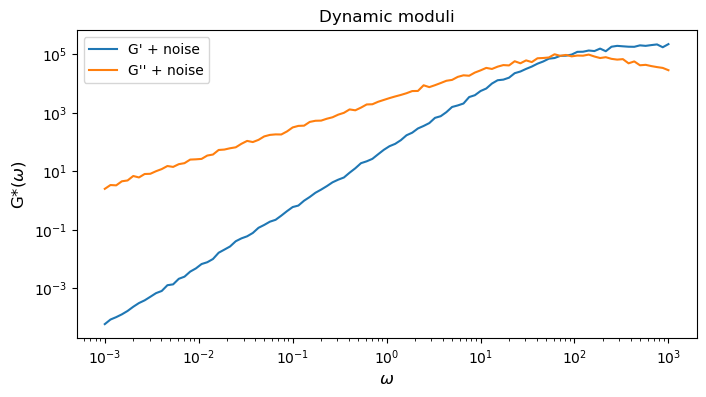

In [16]:
fig = plt.figure(figsize=(8,4),dpi=100)

plt.loglog(omega,np.array(G1_GEX_noise),label='G\' + noise')
plt.loglog(omega,np.array(G2_GEX_noise),label='G\'\' + noise')

plt.legend(loc='upper left')

plt.title(r'Dynamic moduli')
plt.xlabel(r'$\omega$', fontsize=12)
plt.ylabel(r'G*($\omega$)', fontsize=12)
plt.show()

In [17]:
"""
with open('/path/to/G12_dataset2.txt', 'w') as f:
    for i in range(len(omega)):
        d2w = []
        d2w = str(omega[i])+' '+str(G1_GEX_noise[i])+' '+str(G2_GEX_noise[i])+'\n'
        f.write(d2w)
"""

"\nwith open('/path/to/G12_dataset2.txt', 'w') as f:\n    for i in range(len(omega)):\n        d2w = []\n        d2w = str(omega[i])+' '+str(G1_GEX_noise[i])+' '+str(G2_GEX_noise[i])+'\n'\n        f.write(d2w)\n"

### >>> dataset3: Log-normal distribution

In [18]:
### Carrot e Guillet (1997): Log-normal

def wLN(M,sig,Mp):
    return (1/(sig*np.sqrt(2*np.pi)))*(np.exp(-((np.log(M)-np.log(Mp))**2)/(2*sig**2)))

def wLN_integrand(M):
    return ((1/(sig*np.sqrt(2*np.pi)))*(np.exp(-((np.log(M)-np.log(Mp))**2)/(2*sig**2))))/M

In [19]:
mwd_LN = [] #np.zeros((n,1))

sig = 0.25
Mp = 2e5

mwd_LN = wLN(M,sig,Mp)

In [20]:
norm_value_LN = quad(wLN_integrand,min(M),max(M),limit=250)[0]
#interpol_LN = interpolate1d(M, wLN(M,sig,Mp)/norm_value, xspace='log', fill_value='extrapolate')

#integrand_interpol_LN = interpolate1d(M, wLN(M,sig,Mp)/(M*norm_value), xspace='log', fill_value='extrapolate')

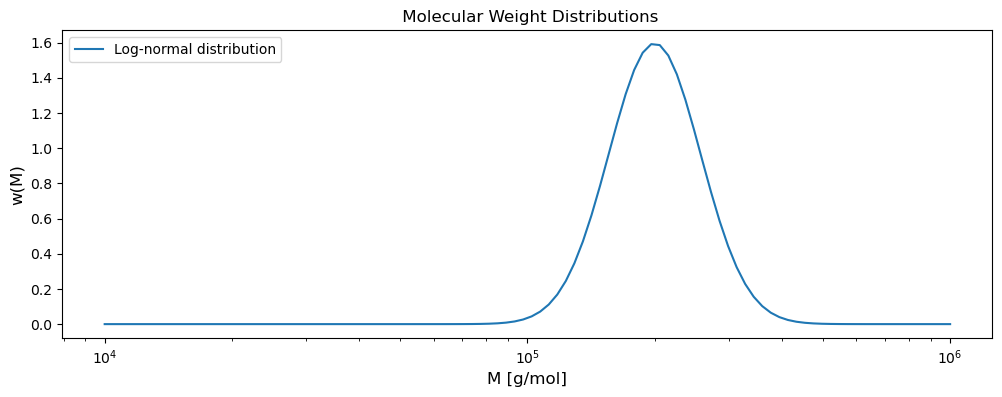

In [28]:
fig = plt.figure(figsize=(12,4),dpi=100)

plt.semilogx(M,mwd_LN,label=r'Log-normal distribution')
#plt.semilogx(M,interpol_LN(M),label=r'Log-normal distribution')

plt.legend(loc='upper left')

plt.title(r' Molecular Weight Distributions')
plt.xlabel(r'M [g/mol]', fontsize=12)
plt.ylabel(r'w(M)', fontsize=12)
plt.show()

In [22]:
part_H_LN  = []

for x in M:
        part_H_LN.append(quad(wLN_integrand,x,max(M),limit=250)[0])
        #part_H_LN.append(quad(integrand_interpol_LN,x,max(M),limit=250)[0])
        
H_model_LN = []
        
H_model_LN = G0*(B/alfa)*wLN(M,sig, Mp)*(np.array(part_H_LN)**(B-1))
#H_model_LN = G0*(B/alfa)*interpol_LN(M)*(np.array(part_H_LN)**(B-1))

H_LN_interp = interpolate1d(tau, H_model_LN, xspace='log', fill_value='extrapolate')

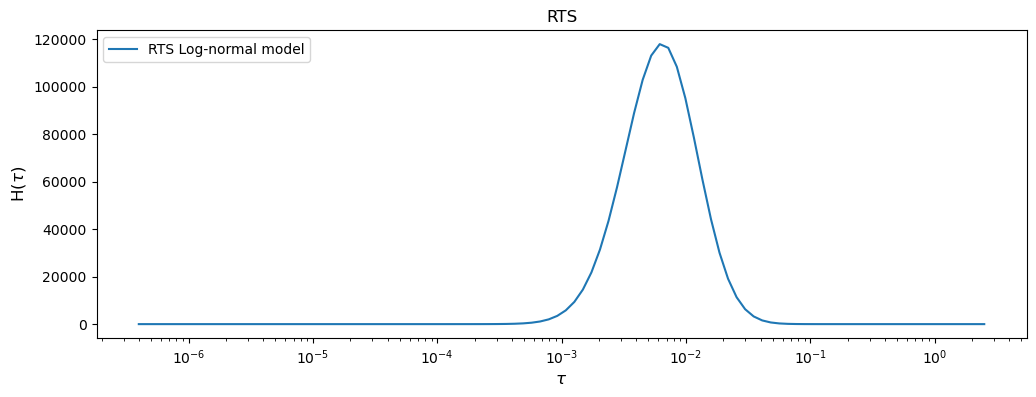

In [29]:
fig = plt.figure(figsize=(12,4),dpi=100)

plt.semilogx(tau,H_model_LN,label='RTS Log-normal model')

plt.legend(loc='upper left')

plt.title(r'RTS')
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'H($\tau$)', fontsize=12)
plt.show()

In [24]:
def G1_LN_integrand(tau):
        return (H_LN_interp(tau)/tau)*(((w*tau)**2)/(1+((w*tau)**2)))
    
def G2_LN_integrand(tau):
        return (H_LN_interp(tau)/tau)*(((w*tau))/(1+((w*tau)**2)))
    
G1_LN, G2_LN = [], []    

for w in omega:
    G1_LN.append(quad(G1_LN_integrand,0,np.inf,limit=250)[0])
    G2_LN.append(quad(G2_LN_integrand,0,np.inf,limit=250)[0])
    
G1_LN = np.array(G1_LN)
G2_LN = np.array(G2_LN)

/tmp/ipykernel_5524/3080115308.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  G2_LN.append(quad(G2_LN_integrand,0,np.inf,limit=250)[0])
/tmp/ipykernel_5524/3080115308.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  G1_LN.append(quad(G1_LN_integrand,0,np.inf,limit=250)[0])


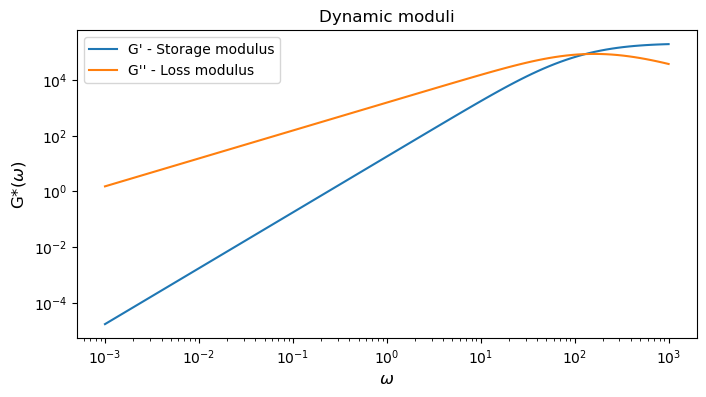

In [30]:
fig = plt.figure(figsize=(8,4),dpi=100)

plt.loglog(omega,np.array(G1_LN),label='G\' - Storage modulus')
plt.loglog(omega,np.array(G2_LN),label='G\'\' - Loss modulus')

plt.legend(loc='upper left')

plt.title(r'Dynamic moduli')
plt.xlabel(r'$\omega$', fontsize=12)
plt.ylabel(r'G*($\omega$)', fontsize=12)
plt.show()

In [26]:
"""
with open('/path/to/MWD_dataset3.txt', 'w') as f:
    for i in range(len(M)):
        d2w = []
        d2w = str(M[i])+' '+str(mwd_LN[i])+'\n'
        f.write(d2w)
        
with open('/path/to/G12_dataset3.txt', 'w') as f:
    for i in range(len(omega)):
        d2w = []
        d2w = str(omega[i])+' '+str(G1_LN[i])+' '+str(G2_LN[i])+'\n'
        f.write(d2w)
"""

"\nwith open('/path/to/MWD_dataset3.txt', 'w') as f:\n    for i in range(len(M)):\n        d2w = []\n        d2w = str(M[i])+' '+str(mwd_LN[i])+'\n'\n        f.write(d2w)\n        \nwith open('/path/to/G12_dataset3.txt', 'w') as f:\n    for i in range(len(omega)):\n        d2w = []\n        d2w = str(omega[i])+' '+str(G1_LN[i])+' '+str(G2_LN[i])+'\n'\n        f.write(d2w)\n"

In [27]:
Mn, Mw, Mz, MwMn = [], [], [], []
mwd_vr1, mwd_vr2, mwd_vr3, mwd_vr4 = [], [], [], []
int_mwd_vr1, int_mwd_vr2, int_mwd_vr3, int_mwd_vr4 = [], [], [], []

mwd_vr1 = interpolate1d(M, M*mwd_LN, xspace='log', fill_value='extrapolate')
mwd_vr2 = interpolate1d(M, mwd_LN, xspace='log', fill_value='extrapolate')
mwd_vr3 = interpolate1d(M, mwd_LN/M, xspace='log', fill_value='extrapolate')
mwd_vr4 = interpolate1d(M, (M**2)*mwd_LN, xspace='log', fill_value='extrapolate')

int_mwd_vr1 = quad(mwd_vr1, min(M), max(M), limit=250)[0]
int_mwd_vr2 = quad(mwd_vr2, min(M), max(M), limit=250)[0]
int_mwd_vr3 = quad(mwd_vr3, min(M), max(M), limit=250)[0]
int_mwd_vr4 = quad(mwd_vr4, min(M), max(M), limit=250)[0]

Mn = int_mwd_vr2/int_mwd_vr3
Mw = int_mwd_vr1/int_mwd_vr2
Mz = int_mwd_vr4/int_mwd_vr1
MwMn = Mw/Mn

print('Number average molecular weight:', Mn, 'g/mol')
print('Weight average molecular weight:', Mw, 'g/mol')
print('z-Average molecular weight:', Mz, 'g/mol')
print('Polydispersity index:', MwMn, 'g/mol')

/tmp/ipykernel_5524/4044588945.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_mwd_vr1 = quad(mwd_vr1, min(M), max(M), limit=250)[0]
/tmp/ipykernel_5524/4044588945.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_mwd_vr2 = quad(mwd_vr2, min(M), max(M), limit=250)[0]
/tmp/ipykernel_5524/4044588945.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_mwd_vr3 = quad(mwd_vr3, min(M), max(M), limit=250)[0]


Number average molecular weight: 206348.68357309856 g/mol
Weight average molecular weight: 219657.02533516067 g/mol
z-Average molecular weight: 233823.69220308927 g/mol
Polydispersity index: 1.0644944350097958 g/mol


/tmp/ipykernel_5524/4044588945.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_mwd_vr4 = quad(mwd_vr4, min(M), max(M), limit=250)[0]
